# Предсказание траекторий пешеходов

## Данные  (https://viratdata.org/ )

## Краткое описание: 
* 11 сцен со стационарных HD камер (1080p или 720p)
* 12 категорий аннотированных активностей [(описание доступно в полной документации к датасету)](https://data.kitware.com/api/v1/file/56f581c88d777f753209c9ce/download)
* Координаты коробок и описание для всех людей в сцене, а также объектов, с которыми они взаимодействуют

## Официальное описание данных

### Annotations files include three types of annotations per clip

* Event file (selected events annotated)
* Mapping file (from event to object) - <span style="color:magenta">*для самого простого способа предсказания траекторий нам нужны только объекты типа person*</span>
* Object file (all objects annotated)

The detailed formats of the above three types of (linked) files are described below.


#### Object file format

Files are named as '%s.viratdata.objects.txt'
Each line captures informabiont about a bounding box of an object (person/car etc) at the corresponding frame.
Each object track is assigned a unique 'object id' identifier. 
Note that:
- an object may be moving or static (e.g., parked car).
- an object track may be fragmented into multiple tracks.

Object File Columns
1. Object id        (a unique identifier of an object track. Unique within a file.)
2. Object duration  (duration of the object track)
3. Currnet frame    (corresponding frame number)
4. bbox lefttop x   (horizontal x coordinate of the left top of bbox, origin is lefttop of the frame)
5. bbox lefttop y   (vertical y coordinate of the left top of bbox, origin is lefttop of the frame)
6. bbox width       (horizontal width of the bbox)
7. bbox height      (vertical height of the bbox)
8. Objct Type       (object type)

Object Type ID (for column 8 above for object files)
1. person
2. car              (usually passenger vehicles such as sedan, truck)
3. vehicles         (vehicles other than usual passenger cars. Examples include construction vehicles)
4. object           (neither car or person, usually carried objects)
5. bike, bicylces   (may include engine-powered auto-bikes)




### Ссылка на датасет: https://data.kitware.com/#collection/56f56db28d777f753209ba9f/folder/56f57e748d777f753209bed7

In [1]:
import os
import re
import requests

import tqdm
from tqdm import notebook
from collections import namedtuple, defaultdict

import pandas as pd 


In [2]:
def kit_folder_content(folderid, mask='', limit=500):
    api_template = 'https://data.kitware.com/api/v1/item?folderId={}&text={}&limit={}&sort=lowerName&sortdir=1'
    url = api_template.format(folderid, mask, limit)
    req = requests.get(url, allow_redirects=True)
    return req.json()


def kit_item_files(itemid, limit=50):
    api_template = 'https://data.kitware.com/api/v1/item/{}/files?limit={}&sort=name&sortdir=1'
    url = api_template.format(itemid, limit)
    req = requests.get(url, allow_redirects=True)
    return req.json()


def kit_download_files(files_json, outname, maxfiles=1):
    with open(outname, 'wb') as outh:
        for file in files_json[0:maxfiles]:
            api_template = 'https://data.kitware.com/api/v1/file/{}/download'
            url = api_template.format(file["_id"])
            req = requests.get(url, allow_redirects=True)
            for chunk in req.iter_content(chunk_size=10**6):
                outh.write(chunk)


# data_dir = os.path.join(os.getcwd(), "data")
data_dir = '/Users/gerrok/virat_dataset/'

virat_annotations_dir = os.path.join(data_dir, 'annotations')
virat_video_dir = os.path.join(data_dir, 'videos_original')
virat_homographies_dir = os.path.join(data_dir, 'homographies')

download_config = [
#     ('5a031a5f8d777f31ac64dfd2', virat_annotations_dir, 'objects'),
#     ('56f581c88d777f753209c9d2', virat_homographies_dir, ''),
]
for dir_id, dir_name, select_mask in download_config:
    try:
        os.mkdir(dir_name)
    except:
        pass
    print("Downloading {}:".format(dir_name))
    for item in notebook.tqdm(kit_folder_content(dir_id, select_mask, 1000)):
        kit_download_files(kit_item_files(item["_id"]), dir_name + "/" + item["name"])


Для семинара вам нужны только гомографии и видео + аннотации одной сцены. 

Чтобы скачать все данные, нужно раскомментить аннотации в download_config-е.

Если вам понадобится скачать дополнительно какие-то ещё данные, то заполните конфиг по аналогии: уникальный ID папки (Folder information/Unique ID с сайта data.kitware.com), куда качать, подстрока для фильтрации файлов, если нужно

In [4]:
# ! mkdir -p $virat_annotations_dir 
# ! wget https://data.kitware.com/api/v1/item/56f57e748d777f753209bedf/download -O $virat_annotations_dir/VIRAT_S_000001.viratdata.objects.txt

# тут качается видео сцены (1.36Gb), нам оно необходимо только для отрисовки примера сцены 
# вы можете не скачивать видео и не перезапускать ячейки с отрисовкой
# ! mkdir -p $virat_video_dir
# ! wget https://data.kitware.com/api/v1/item/56f581ce8d777f753209ca44/download -O $virat_video_dir/VIRAT_S_000001.mp4

In [3]:
def get_scene_id(name):
    return re.findall(r'\d{4}', name)[0]

In [4]:
def get_record_id(name):
    return re.findall(r'\d{6}', name)[0]

In [5]:
record_id_to_video_filename = {
    get_record_id(fn): os.path.join(virat_video_dir, fn)
    for fn in os.listdir(virat_video_dir)
}
record_id_to_object_annotation_filename = {
    get_record_id(fn): os.path.join(virat_annotations_dir, fn)
    for fn in os.listdir(virat_annotations_dir)
}
scene_id_to_scene_homographies_filename = {
    get_scene_id(fn): os.path.join(virat_homographies_dir, fn)
    for fn in os.listdir(virat_homographies_dir)
    if fn.endswith('homography_img2world.txt')
}
scene_id_to_scene_homographies_imgs = {
    get_scene_id(fn): os.path.join(virat_homographies_dir, fn)
    for fn in os.listdir(virat_homographies_dir)
    if fn.endswith('.png')
}

In [6]:
ObjectTypes = namedtuple('ObjectTypes', ['PERSON', 'CAR', 'VEHICLE', 'OBJECT', 'BIKE'])
virat_object_types = ObjectTypes(
    PERSON = 1,
    CAR = 2,
    VEHICLE = 3,
    OBJECT = 4,
    BIKE = 5,
)

OBJECT_ANNOTATION_FIELDS = [
    'object_id', 'object_duration', 'current_frame', 'left_top_x', 'left_top_y', 'width', 'height', 'object_type']


In [7]:
def record_id2scene_id(record_id):
    return record_id[:4]

def record_id_to_homography(record_id):
    scene_id = record_id2scene_id(record_id)
    return scene_id_to_scene_homographies_filename[scene_id], \
           scene_id_to_scene_homographies_imgs[scene_id]

In [8]:
record_id = '000001'

object_annotation_filename = record_id_to_object_annotation_filename[record_id]
scene_homography_filename, scene_homography_img = record_id_to_homography(record_id)


In [9]:
video_filename = record_id_to_video_filename[record_id]

In [10]:
# Прочитаем данные и отберём все записи с людьми
df = pd.read_csv(object_annotation_filename, delim_whitespace=True, names=OBJECT_ANNOTATION_FIELDS)
df = df[df.object_type.isin([virat_object_types.PERSON])]

In [13]:
df.head(20)

,object_id,object_duration,current_frame,left_top_x,left_top_y,width,height,object_type
0,1,385,3455,1,663,76,132,1
1,1,385,3456,1,663,76,132,1
2,1,385,3457,1,663,76,132,1
3,1,385,3458,1,663,76,132,1
4,1,385,3459,1,663,76,132,1
5,1,385,3460,1,663,76,132,1
6,1,385,3461,1,663,76,132,1
7,1,385,3462,1,663,76,132,1
8,1,385,3463,5,663,76,132,1
9,1,385,3464,10,663,76,132,1


## Посмотрим на данные глазами

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [15]:
# найдём одну из сцен с максимальным количеством людей на ней
frame_id = df.groupby(['current_frame']).size().sort_values(ascending=False).index[0]

In [16]:
frame_id

9659

In [17]:
def get_track(df, object_id, frame_bounds):
    df = df[df.object_id == object_id]
    if frame_bounds[0] is not None and frame_bounds[1] is not None:
        assert frame_bounds[0] <= frame_bounds[1]
        track = df[np.logical_and(df.current_frame >= frame_bounds[0], df.current_frame < frame_bounds[1])]
    elif frame_bounds[0] is not None:
        track = df[df.current_frame >= frame_bounds[0]]
    elif frame_bounds[1] is not None:
        track = df[df.current_frame < frame_bounds[1]]
    else:
        return df
    return track

In [18]:
def get_track_coordinates(track, decimation_rate=6):
    # https://en.wikipedia.org/wiki/Downsampling_(signal_processing)
    coords = np.concatenate([
        [np.array(track.left_top_x + track.width / 2)], 
        [np.array(track.left_top_y + track.height)]
    ]).transpose((1,0))
    coords = coords[:coords.shape[0] - coords.shape[0] % decimation_rate, :].reshape(
        (coords.shape[0] // decimation_rate, decimation_rate, coords.shape[1]))
    coords = np.median(coords, axis=1)
    return coords.astype(np.int32)

 ### Отрисуем треки на кадре из видео:

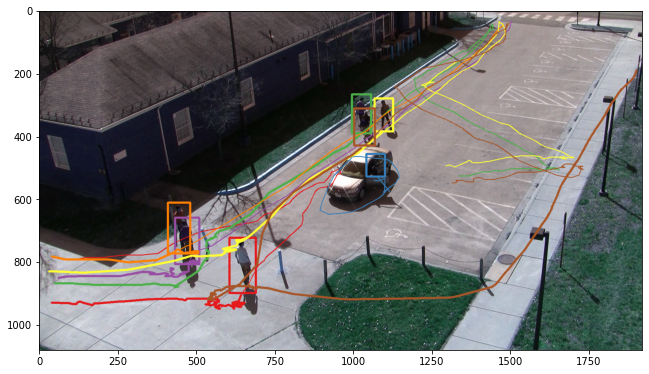

In [19]:
cap = cv2.VideoCapture(video_filename)

cap.set(1, frame_id)
ret, frame = cap.read()

img = frame.copy()
colors = [(228,26,28), (55,126,184), (77,175,74), (152,78,163), (255,127,0), (255,255,51), (166,86,40), (247,129,191)]
for i, (row_ind, row) in enumerate(df[df.current_frame == frame_id].iterrows()):
    cv2.rectangle(
        img, 
        (row.left_top_x, row.left_top_y), 
        (row.left_top_x + row.width, row.left_top_y + row.height), 
        colors[i], 5)
    track = get_track(df, row.object_id, (None, row.current_frame))
    coords = get_track_coordinates(track)
    cv2.polylines(img, [coords], False, colors[i], 5)
    
    track = get_track(df, row.object_id, (row.current_frame, None))
    coords = get_track_coordinates(track)
    cv2.polylines(img, [coords], False, colors[i], 2)

plt.figure(figsize=(10.8, 19.2))
plt.imshow(img)
plt.show()


In [20]:
# посмотрим FPS видео, чтобы понять, сколько точек мы хотим предсказывать
cap.get(cv2.CAP_PROP_FPS)

29.97002997002997

Обычно предсказывают на 5 или 10 секунд вперёд, мы будем  предсказывать на 5 секунд вперёд по 0.4 секунды на горизонт

## Теперь нужно перевести треки в мировые координаты

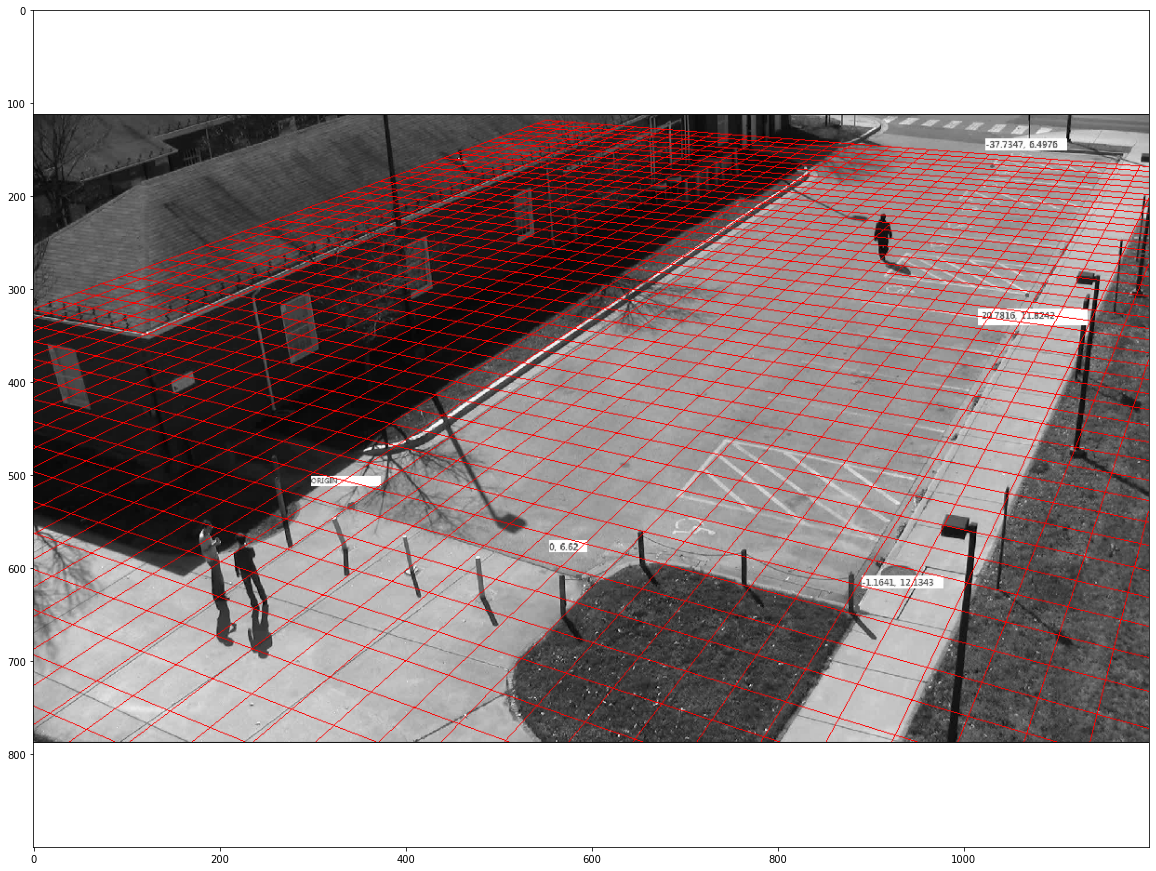

In [21]:
# отрисуем картинку, демонстрирующую нужное преобразование

plt.figure(figsize=(20, 40))
plt.imshow(cv2.imread(scene_homography_img))
plt.show()

In [22]:
# матрица гомографии нашей сцены
H = np.loadtxt(scene_homography_filename, dtype=np.float, delimiter=',')
H

array([[-2.5796104e-04,  9.3565491e-04, -4.9343613e-01],
       [ 5.7183404e-04,  8.2778391e-04, -8.6963374e-01],
       [ 1.5464549e-06,  4.0565615e-05,  1.6012838e-02]])

## Гомография

Матрица гомографии в данном контексте - это матрица проективного преобразования координат плосткости поверхности земли на изображении в bird's-eye view 

## Описание гомографии из документации

Each homography H provides a mapping from image coordinate to scene-dependent world coordinate.

$$[xw,yw,zw] = H*[xi,yi,1]$$


$xi$: horizontal axis on image with left top corner as origin, increases right. 

$yi$: vertical axis on image with left top corner as origin, increases downward.

$xw/zw$: world x coordinate

$yw/zw$: world y coordiante



In [23]:
def transform(input_xy, H):
    coords = np.ones((input_xy.shape[0], 3))
    coords[:, :2] = input_xy
    word_frame_coords = H.dot(coords.T).T
    word_frame_coords[:, 0] /= word_frame_coords[:, 2]
    word_frame_coords[:, 1] /= word_frame_coords[:, 2]
    return word_frame_coords[:, :2]


##  Нарисуем преобразованные треки и референсные точки 

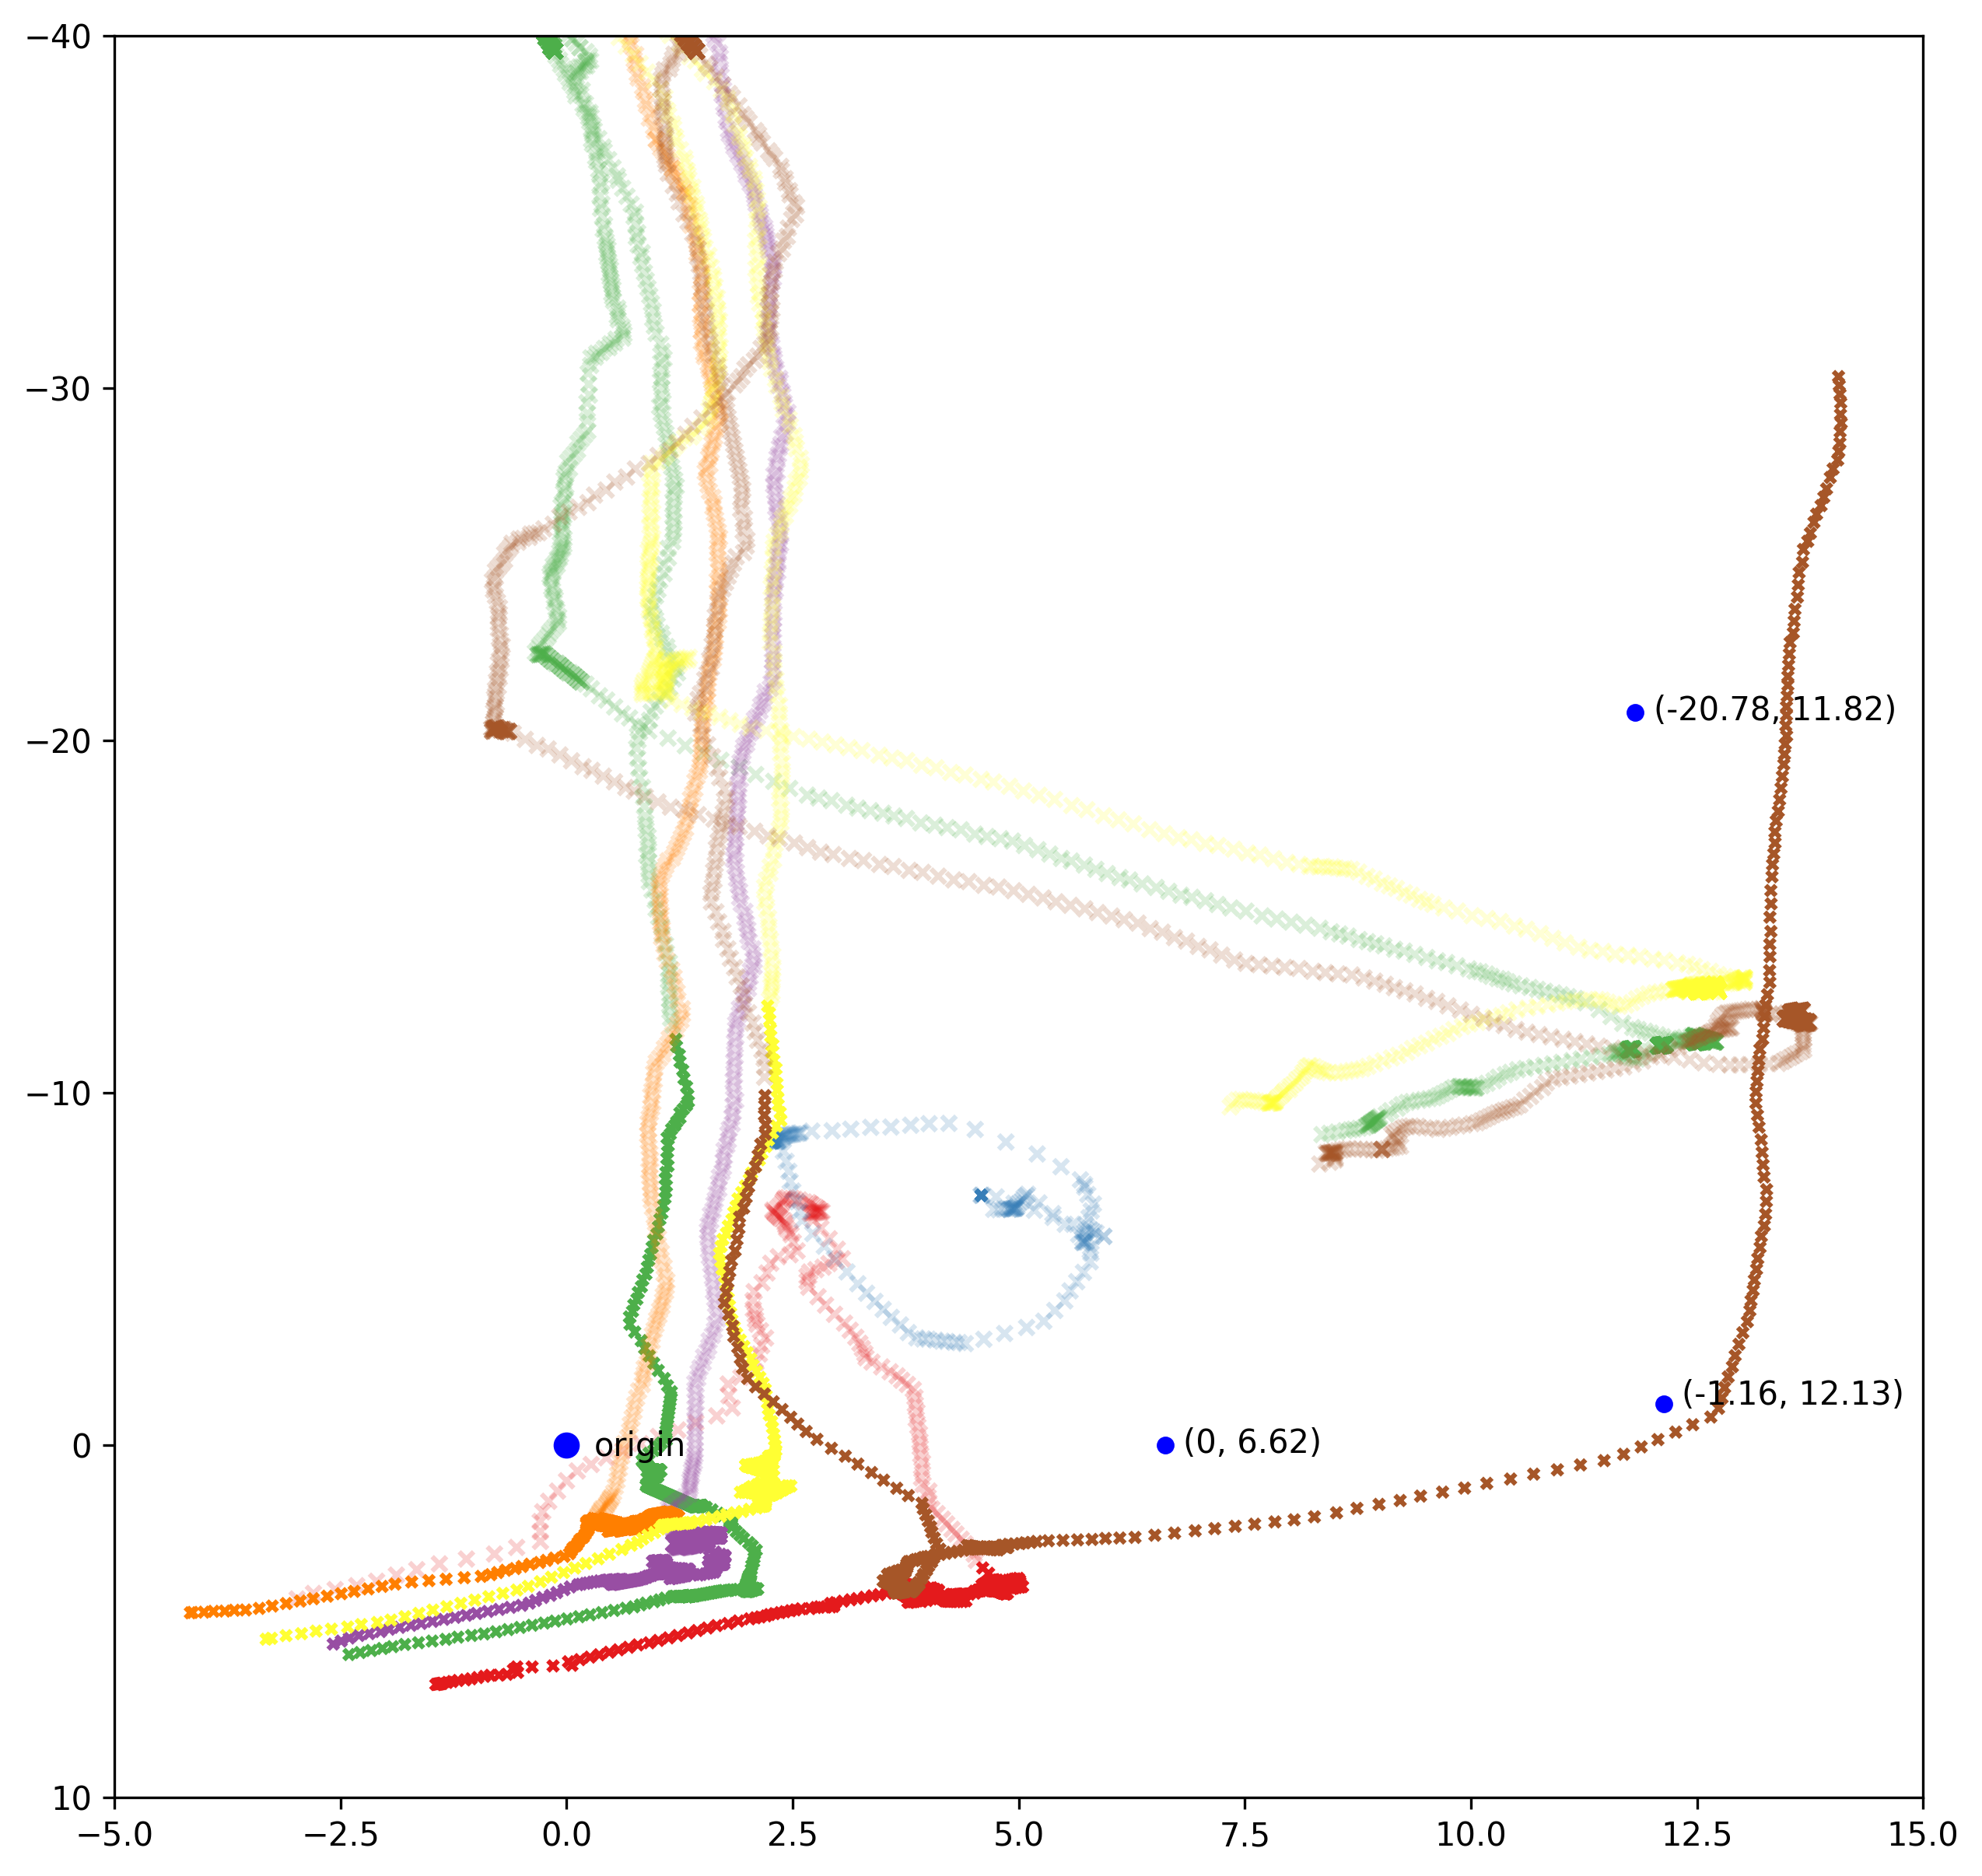

In [24]:
plt.figure(figsize=(10, 10), dpi=300)

for i, (row_ind, row) in enumerate(df[df.current_frame == frame_id].iterrows()):
    track = get_track(df, row.object_id, (None, row.current_frame))
    coords = get_track_coordinates(track)
    word_frame_coords = transform(coords, H)
    plt.scatter(
        word_frame_coords[:, 1],
        word_frame_coords[:, 0],
        c=np.tile(colors[i], (word_frame_coords.shape[0], 1)).astype(np.float) / 255,
        marker='x',
        s=10)
    
    track = get_track(df, row.object_id, (row.current_frame, None))
    coords = get_track_coordinates(track)
    word_frame_coords = transform(coords, H)
    plt.scatter(
        word_frame_coords[:, 1],
        word_frame_coords[:, 0],
        c=np.tile(colors[i], (word_frame_coords.shape[0], 1)).astype(np.float) / 255,
        s=20,
        marker='x',
        alpha=0.2)

plt.xlim((-5, 15))
plt.ylim((10,-40))

plt.scatter(0, 0, c='b', s=50)
plt.annotate('origin', xy=(0, 0), xytext=(0.3, 0.3))

plt.scatter(6.62, 0, c='b', s=20)
plt.annotate('(0, 6.62)', xy=(0, 0), xytext=(6.82, 0.2))

plt.scatter(12.13, -1.16, c='b', s=20)
plt.annotate('(-1.16, 12.13)', xy=(0, 0), xytext=(12.33, -1.16))

plt.scatter(11.82, -20.78, c='b', s=20)
plt.annotate('(-20.78, 11.82)', xy=(0, 0), xytext=(12.02, -20.58))

plt.show()

In [25]:
record_id_to_object_annotations = dict()
for record_id, filename in record_id_to_object_annotation_filename.items():
    dataframe = pd.read_csv(filename, delim_whitespace=True, names=OBJECT_ANNOTATION_FIELDS)
    dataframe = dataframe[dataframe.object_type == virat_object_types.PERSON]
    if record_id in record_id_to_object_annotations:
        record_id_to_object_annotations[record_id] = pd.concat([
            record_id_to_object_annotations[record_id], dataframe
        ])
    else:
        record_id_to_object_annotations[record_id] = dataframe
        
scene_id_to_homography = dict()
for scene_id, filename in scene_id_to_scene_homographies_filename.items():
    scene_id_to_homography[scene_id] = np.loadtxt(filename, dtype=np.float, delimiter=',')

In [26]:
scene_id_to_record_ids = defaultdict(list)
for record_id in record_id_to_object_annotation_filename.keys():
    scene_id = record_id2scene_id(record_id)
    scene_id_to_record_ids[scene_id].append(record_id)

## Посмотрим на статистику по сценам

Так как датасет не гарантирует нам сквозные id объектов, будем семплировать траектории внутри record_id

In [27]:
for scene_id, record_ids in sorted(scene_id_to_record_ids.items()):
    for record_id in sorted(record_ids):
        print(
            "Scene %s record %s contains %3d unique objects and %7d rows in dataset" % (
                scene_id, 
                record_id, 
                len(record_id_to_object_annotations[record_id].object_id.unique()), 
                len(record_id_to_object_annotations[record_id])
            )
        )

Scene 0000 record 000001 contains  11 unique objects and   84008 rows in dataset
Scene 0000 record 000002 contains   7 unique objects and   43532 rows in dataset
Scene 0000 record 000003 contains   6 unique objects and    9530 rows in dataset
Scene 0000 record 000004 contains   4 unique objects and   14542 rows in dataset
Scene 0000 record 000006 contains  11 unique objects and   21196 rows in dataset
Scene 0001 record 000101 contains  37 unique objects and   66155 rows in dataset
Scene 0001 record 000102 contains  76 unique objects and  147449 rows in dataset
Scene 0002 record 000200 contains   1 unique objects and     342 rows in dataset
Scene 0002 record 000201 contains   2 unique objects and    9054 rows in dataset
Scene 0002 record 000202 contains  12 unique objects and   26466 rows in dataset
Scene 0002 record 000203 contains   0 unique objects and       0 rows in dataset
Scene 0002 record 000205 contains   3 unique objects and    3473 rows in dataset
Scene 0002 record 000206 con

## Разделим датасет по сценам на трейн, тест и валидацию

In [28]:
VALIDATION_SCENE_IDS = ['0000']
TEST_SCENE_IDS = ['0002']
TRAIN_SCENE_IDS = ['0100', '0101', '0102', '0001', '0400', '0401', '0500', '0502', '0503']

In [29]:
def process_track(track, H, history_length, prediction_length, decimation_rate, track_mode):
    coordinates = transform(
        get_track_coordinates(track.sort_values('current_frame'), decimation_rate=decimation_rate), H)
    if track_mode == 'diff':
        coordinates = coordinates[1:, :] - coordinates[:-1, :]
    elif track_mode == 'relative':
        coordinates = coordinates - coordinates[history_length - 1]
    elif track_mode == 'absolute':
        pass
    else:
        ValueError('Unknown mode %s' % track_mode)
    return coordinates[:history_length], coordinates[history_length:history_length+prediction_length]
        

def deterministic_data_generator(
        scene_ids, 
        history_length, prediction_length, decimation_rate, 
        batch_size=16, generator_length=None, track_mode='relative', stop_on_end=False):
    def internal_generator(scene_id, record_id):
        df = record_id_to_object_annotations[record_id]
        H = scene_id_to_homography[scene_id]
        all_object_ids = df.object_id.unique()
        if len(all_object_ids) == 0:
            return
        batch_features = []
        batch_gt = []
        generated_batches = 0
        for object_id in all_object_ids:
            full_track = get_track(df, object_id, (None, None))
            for row_id in range(0, len(full_track), history_length * decimation_rate):
                start_point = full_track.iloc[row_id]
                track = get_track(
                    df, object_id, 
                    (start_point.current_frame, 
                     start_point.current_frame + (prediction_length + history_length + 1) * decimation_rate))
                if len(track) != (prediction_length + history_length + 1) * decimation_rate:
                    continue
                X, y = process_track(track, H, history_length, prediction_length, decimation_rate, track_mode)
                batch_features.append(X)
                batch_gt.append(y)
                if len(batch_features) == batch_size:
                    yield np.concatenate([batch_features]), np.concatenate([batch_gt])
                    generated_batches += 1
                    if generator_length and generated_batches == generator_length:
                        return 
                    batch_features = []
                    batch_gt = []
    while True:
        for scene_id in scene_ids:
            for record_id in scene_id_to_record_ids[scene_id]:
                for X, y in internal_generator(scene_id, record_id):
                    yield X, y 
        if stop_on_end:
            return

def random_data_generator(
        scene_ids, 
        history_length, prediction_length, 
        batch_size, decimation_rate, track_mode='relative'):
    while True:
        scene_id = np.random.choice(scene_ids)
        record_id = np.random.choice(scene_id_to_record_ids[scene_id])
        df = record_id_to_object_annotations[record_id]
        H = scene_id_to_homography[scene_id]
        all_object_ids = df.object_id.unique()
        if len(all_object_ids) == 0:
            continue
        batch_features = []
        batch_gt = []        
        while len(batch_features) < batch_size:
            object_id = np.random.choice(all_object_ids)
            full_track = get_track(df, object_id, (None, None))
            start_point = full_track.sample(1).iloc[0]
            track = get_track(
                df, object_id, 
                (start_point.current_frame - (history_length + 1) * decimation_rate, start_point.current_frame + prediction_length * decimation_rate))
            if len(track) != (prediction_length + history_length + 1) * decimation_rate:
                continue
            X, y = process_track(track, H, history_length, prediction_length, decimation_rate, track_mode)
            batch_features.append(X)
            batch_gt.append(y)
        yield np.concatenate([batch_features]), np.concatenate([batch_gt])


In [30]:
# Зададим параметры генераторов следующим образом

# Коэффициент прореживания для достижения длины одного горизонта в 0.4 секунды 
decimation_rate = 6
# Длина доступной истории - 2.4 секунды
history_length = 6 
# Самый дальний горизонт предсказания - 5.2 секунды
prediction_length = 13 

track_mode = 'absolute'

In [31]:
test_generator = random_data_generator(TEST_SCENE_IDS, batch_size=8, history_length=history_length, prediction_length=prediction_length, decimation_rate=decimation_rate, track_mode=track_mode)

In [34]:
%%time
X, y = next(test_generator)

CPU times: user 30.7 ms, sys: 1.6 ms, total: 32.3 ms
Wall time: 31 ms


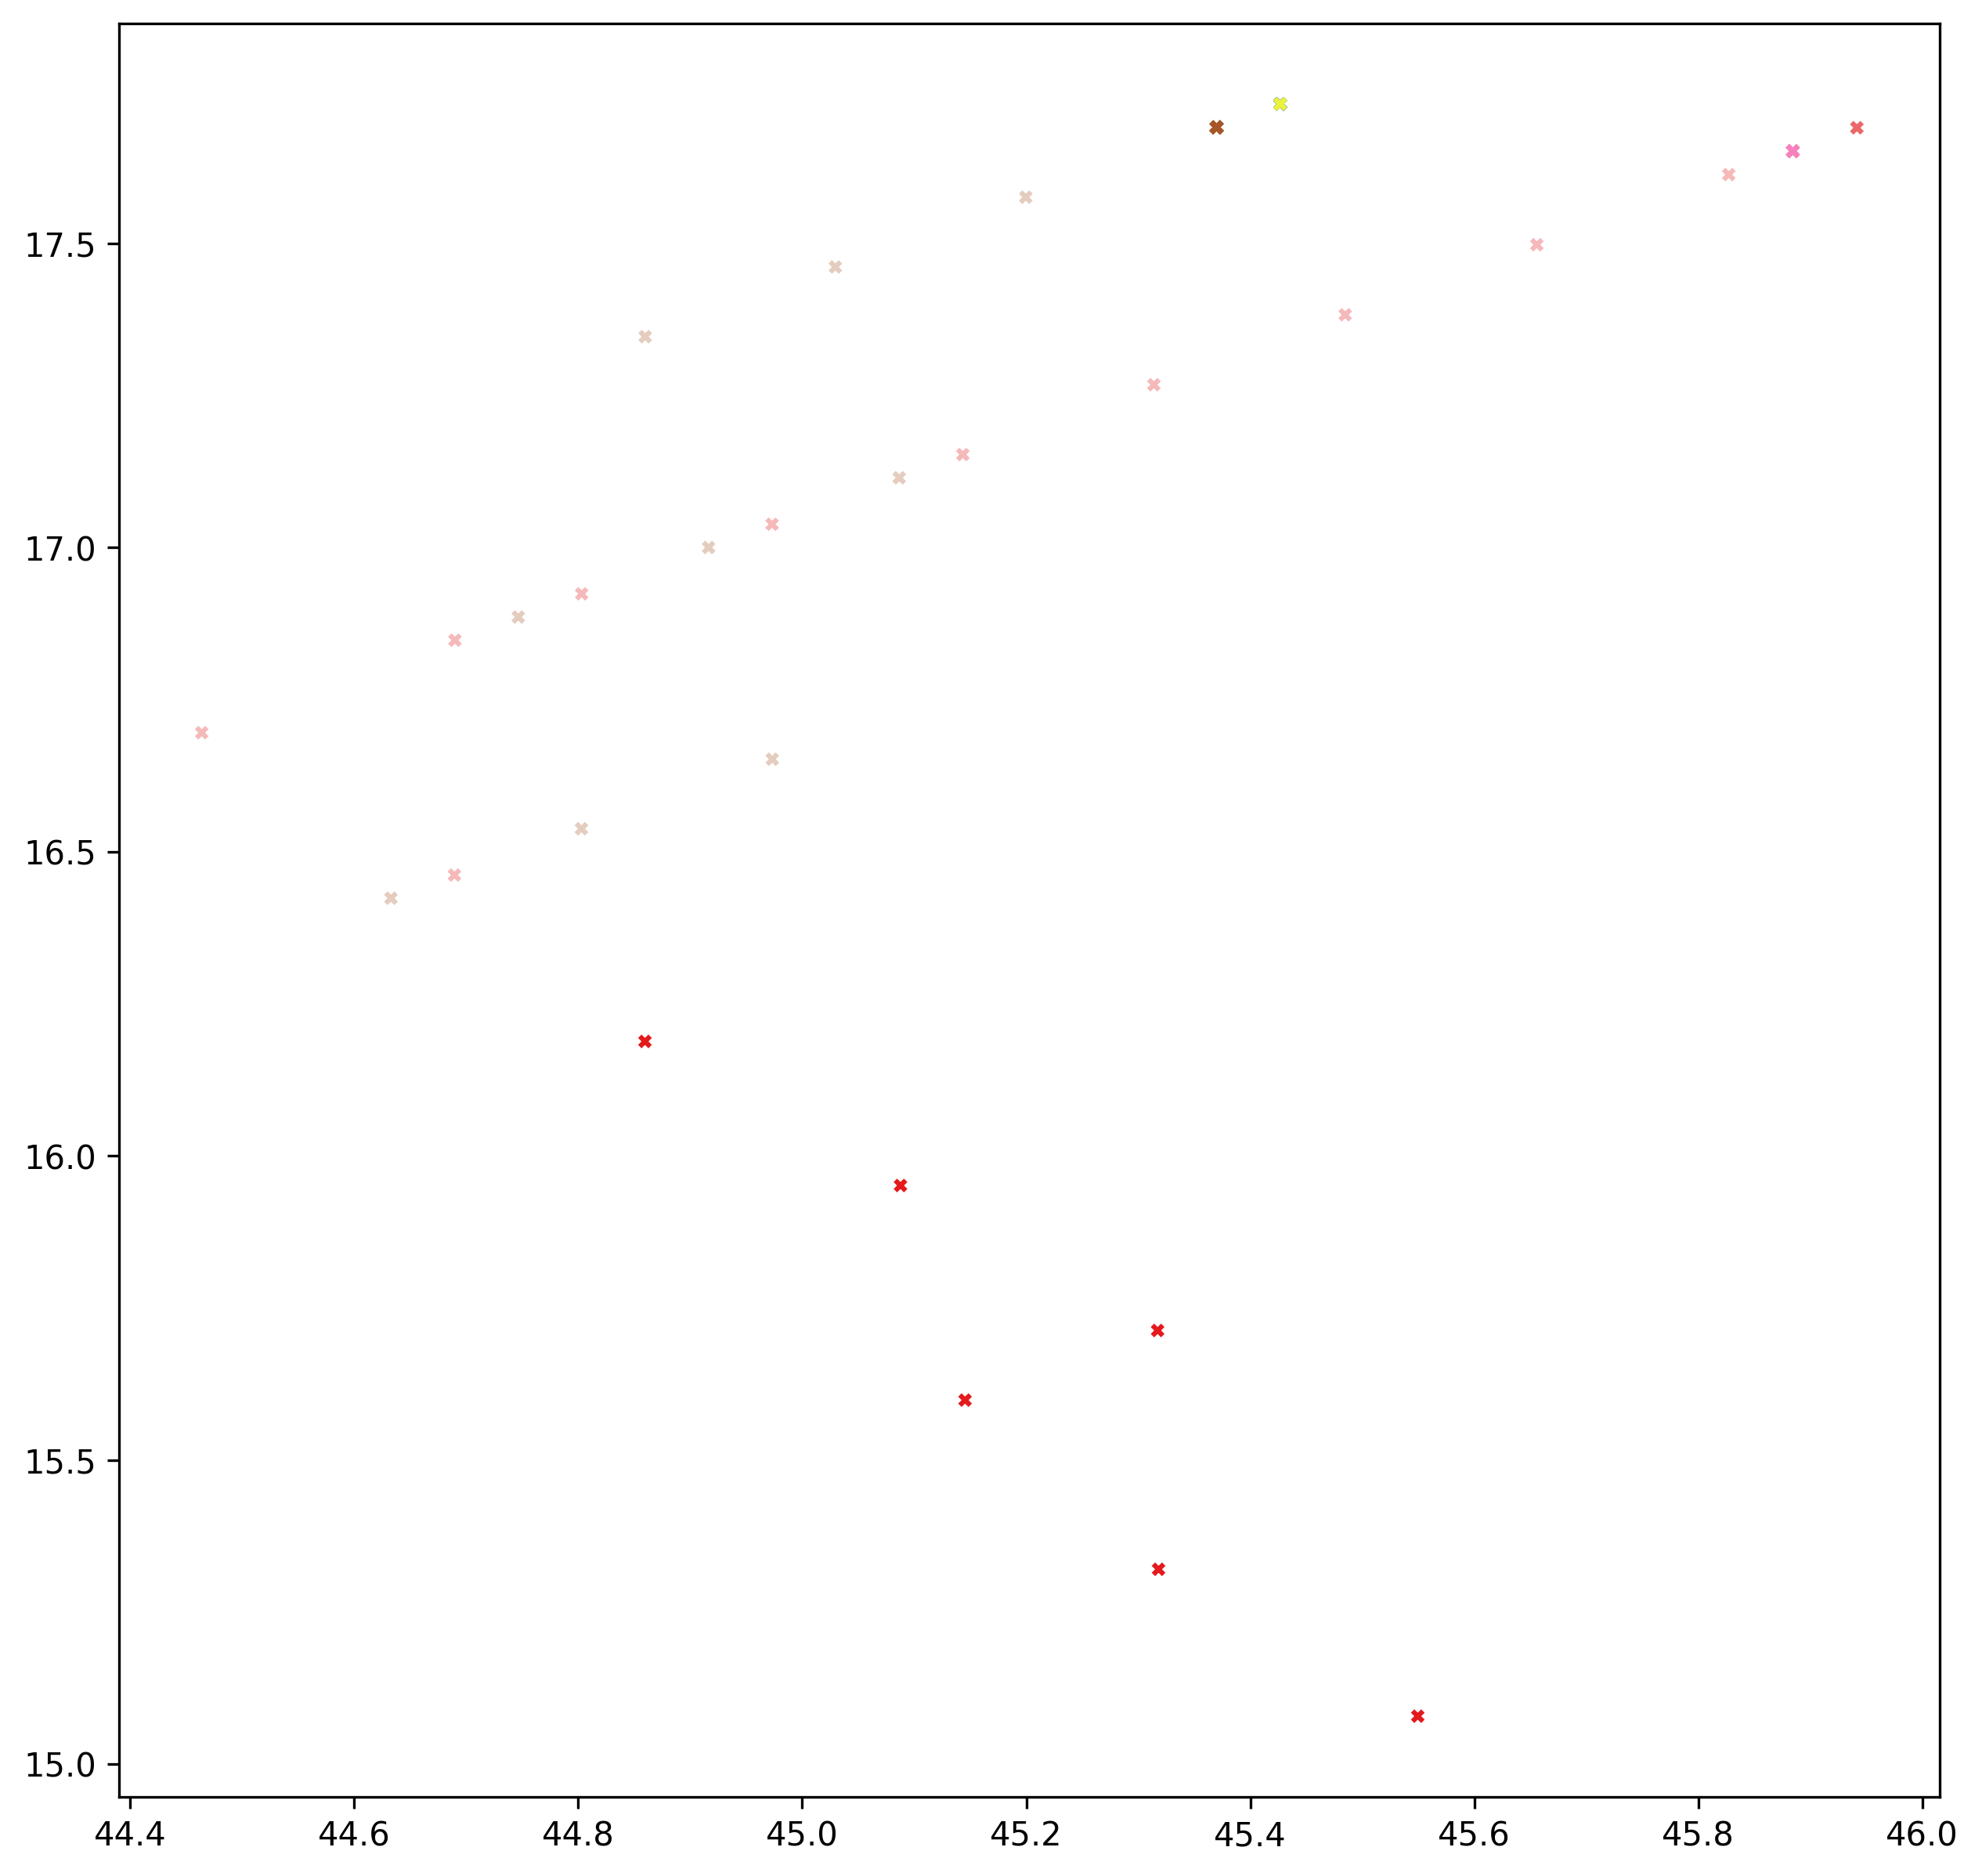

In [35]:
plt.figure(figsize=(10, 10), dpi=300)

for i in range(min(X.shape[0], len(colors))):
    plt.scatter(
        X[i, :, 1], X[i, :, 0],
        c=np.tile(colors[i], (X.shape[1], 1)).astype(np.float) / 255,
        marker='x',
        s=10)
    plt.scatter(
        y[i, :, 1], y[i, :, 0],
        c=np.tile(colors[i], (y.shape[1], 1)).astype(np.float) / 255,
        s=10,
        marker='x',
        alpha=0.3)

#  Метрики и модели

## Какие метрики принято публиковать?
* Average displacement error - mean L2 over all estimated points of a trajectory and the true points.
* $MinADE_k$ - the minimum average displacement error over k most likely trajectories.
* Final displacement error - the distance between the predicted final destination and the true final destination at end of the prediction period $T_{pred}$.
* $MinFDE_k$ - the minimum final displacement error over k most likely trajectories.
* Average non-linear displacement error - The is the MSE at the non-linear regions of a trajectory. 


## Модель без ML - фильтр Калмана

In [36]:
#kalman_xy source: https://stackoverflow.com/a/13903992

linear_motion_F = np.matrix('''
                      1. 0. 1. 0.;
                      0. 1. 0. 1.;
                      0. 0. 1. 0.;
                      0. 0. 0. 1.
                      ''')

def kalman_xy(x, P, measurement, R,
              motion = np.matrix('0. 0. 0. 0.').T,
              Q = np.matrix(np.eye(4))):
    """
    Parameters:    
    x: initial state 4-tuple of location and velocity: (x0, x1, x0_dot, x1_dot)
    P: initial uncertainty convariance matrix
    measurement: observed position
    R: measurement noise 
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    """
    return kalman(x, P, measurement, R, motion, Q,
                  F = linear_motion_F,
                  H = np.matrix('''
                      1. 0. 0. 0.;
                      0. 1. 0. 0.'''))

def kalman(x, P, measurement, R, motion, Q, F, H):
    '''
    Parameters:
    x: initial state
    P: initial uncertainty covariance matrix
    measurement: observed position (same shape as H*x)
    R: measurement noise (same shape as H)
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    F: next state function: x_prime = F*x
    H: measurement function: position = H*x

    Return: the updated and predicted new values for (x, P)

    See also http://en.wikipedia.org/wiki/Kalman_filter

    This version of kalman can be applied to many different situations by
    appropriately defining F and H 
    '''
    # UPDATE x, P based on measurement m    
    # distance between measured and current position-belief
    y = np.matrix(measurement).T - H * x
    S = H * P * H.T + R  # residual convariance
    K = P * H.T * S.I    # Kalman gain
    x = x + K*y
    I = np.matrix(np.eye(F.shape[0])) # identity matrix
    P = (I - K*H)*P

    # PREDICT x, P based on motion
    x = F*x + motion
    P = F*P*F.T + Q
    return x, P


def kalman_pred(traj, n_out=5, R = 0.01):
    x = np.matrix('0. 0. 0. 0.').T 
    P = np.matrix(np.eye(4))*1000
    F = linear_motion_F
    for step in range(traj.shape[0]):
        x, P = kalman_xy(x, P, traj[step, :], R)
    x_out = x
    result = np.squeeze(x_out[:2], axis=1).tolist()
    for _ in range(n_out-1):
        x_out = F*x_out
        result += np.squeeze(x_out[:2], axis=1).tolist()
    return np.array(result)

def kalman_pred_batch(trajs, n_out=5, R = 0.01):
    result = []
    for traj_id in range(trajs.shape[0]):
        result += [kalman_pred(trajs[traj_id], n_out, R)]
    return np.array(result)
    

Давайте посчитаем метрики на тесте для фильтра Калмана

Для метрик не забудьте оставить размерность батча

In [37]:
def average_displacement_error(y_true, y_pred):
    return np.mean(np.linalg.norm(y_true - y_pred, axis=2), axis=1)
    
def final_displacement_error(y_true, y_pred):
    return np.linalg.norm(y_true[:,-1] - y_pred[:,-1], axis=1)

In [38]:
predictor_function = lambda x: kalman_pred_batch(x, n_out=prediction_length)

In [39]:
def eval_on_test(
        predictor_function,
        history_length, prediction_length, 
        batch_size, decimation_rate, track_mode='relative',
        scene_ids=TEST_SCENE_IDS,
        metrics_functions=[average_displacement_error, final_displacement_error]):
    test_generator = deterministic_data_generator(scene_ids, batch_size=batch_size, history_length=history_length, prediction_length=prediction_length, decimation_rate=decimation_rate, track_mode=track_mode, stop_on_end=True)
    metrics_values = defaultdict(list)
    for X, y in tqdm.tqdm(test_generator):
        prediction = predictor_function(X)
        for metrics_function in metrics_functions:
            metrics_values[metrics_function.__name__] += list(metrics_function(y, prediction))
    result = dict()
    for metrics_function in metrics_functions:
        result[metrics_function.__name__] = np.mean(metrics_values[metrics_function.__name__])
    return result

In [40]:
result = eval_on_test(
    predictor_function,
    history_length=history_length,
    prediction_length=prediction_length,
    decimation_rate=decimation_rate,
    batch_size=64)

14it [00:04,  3.27it/s]


In [41]:
for metric_name, metric_val in result.items():
    print('%s: %.3f' % (metric_name, metric_val))

average_displacement_error: 0.561
final_displacement_error: 1.161


# Посмотрим на предсказания

In [46]:
track_mode = 'absolute'
test_generator = random_data_generator(
    TEST_SCENE_IDS,
    batch_size=10,
    history_length=history_length,
    prediction_length=prediction_length,
    decimation_rate=decimation_rate,
    track_mode=track_mode)

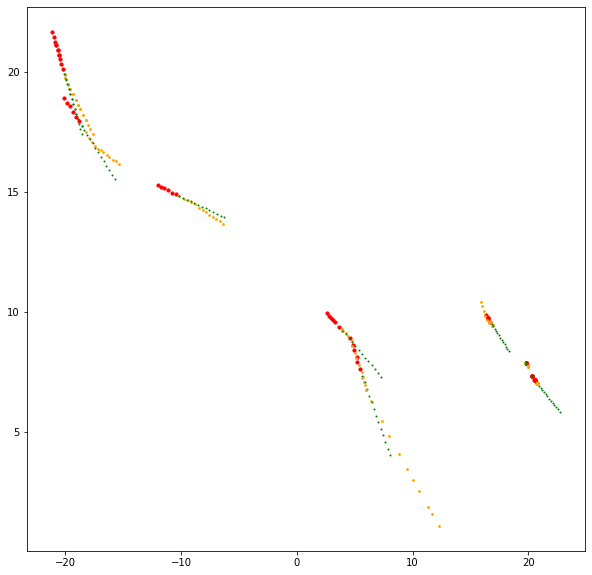

In [47]:
X, y = next(test_generator)
kalman_prediction = kalman_pred_batch(X, n_out=prediction_length)
plt.figure(figsize=(10, 10))

for i in range(0, len(X)):
    plt.scatter(X[i, :, 1], X[i, :, 0], c='r', s=10)
    plt.scatter(y[i, :, 1], y[i, :, 0], c='orange', s=3)
    plt.scatter(kalman_prediction[i, :, 1], kalman_prediction[i, :, 0], c='g', s=1)
plt.show()

## Какие модели мы будем обсуждать и где почитать подробнее?
* #### Peeking into the Future: Predicting Future Person Activities and Locations in Videos (CVPR 2019)
    - https://arxiv.org/abs/1902.03748 - ссылка на статью
    - https://github.com/google/next-prediction - ссылка на код
  
* #### Social LSTM: Human Trajectory Prediction in Crowded Spaces (CVPR 2016)
    - http://openaccess.thecvf.com/content_cvpr_2016/papers/Alahi_Social_LSTM_Human_CVPR_2016_paper.pdf - ссылка на статью
* #### Social GAN: Socially Acceptable Trajectories with Generative Adversarial Networks (CVPR 2019)
    - https://arxiv.org/abs/1803.10892 - ссылка на статью
    - https://github.com/agrimgupta92/sgan - ссылка на код
* #### SoPhie: An Attentive GAN for Predicting Paths Compliant to Social and Physical Constraints
    - https://arxiv.org/pdf/1806.01482.pdf - ссылка на статью

### Шаблон для обучения модели

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K


In [ ]:
track_mode = 'relative'
batch_size = 64

In [ ]:
input_layer = keras.layers.Input(shape=(history_length, 2), batch_size=batch_size)
# your code 
output_layer = keras.layers.TimeDistributed(keras.layers.Dense(2), name='decoder_result')(layer)

In [ ]:
model = keras.Model(inputs=[input_layer], outputs=[output_layer])

In [ ]:
! mkdir -p models

In [ ]:
model.compile(
    # params
)

In [ ]:
validation_steps = 50

train_generator = random_data_generator(TRAIN_SCENE_IDS, batch_size=batch_size, history_length=history_length, prediction_length=prediction_length, track_mode=track_mode, decimation_rate=decimation_rate)
val_generator = deterministic_data_generator(VALIDATION_SCENE_IDS, generator_length=validation_steps, batch_size=batch_size, history_length=history_length, prediction_length=prediction_length, track_mode=track_mode, decimation_rate=decimation_rate)


In [ ]:
model.fit_generator(
    train_generator, steps_per_epoch=# your choice, 
    validation_data=val_generator, validation_steps=validation_steps, 
    # params
)

In [ ]:
model.load_weights('models/best_model.h5')

## Задание
1. Реализуйте ml-модель предсказания траектории и обучите до сходимости любым удобным вам способом (суммарно 4 балла)
    * модель сошлась и предсказывает не рандомные траектории (1 балл)
    * это нейросетевая модель (1 балл)
    * нарисуйте 5-10 примеров предсказания, где модель визуально и по метрикам ведёт себя лучше фильтра Калмана (2 балла)    
2. Посчитайте метрики: ADE и FDE по сценам, ADE и FDE для траекторий без стоящих пешеходов по сценам (2 балла). В этом пункте важно самостоятельно определить, кто такой "стоящий пешеход", и написать обоснование.

3. Модель удовлетворяет условиям из пункта (1) и обыгрывает фильтр Калмана по всем метрикам из пункта (2) на тесте (4 балла - по баллу за каждую метрику)

По итогам этого задания ожидается читаемый отчёт с текстовыми комментариями, метриками на тесте, примерами предсказания. Результаты, не вошедшие в отчёт, в финальной оценке засчитаны не будут. 

Суммарно - 10 баллов за задание.